# Building Bonsai BDT for Online Triggering

* Step 1 : Pull out features for classification.  These include energy deposit on wire, energy deposit of left neighbour, energy deposit of right neighbour, and layer id (radial distance).
* Step 2 : Bin these features into 11 bins, 10 with deposits, one with no deposits
* Step 3 : Train the GBDT to recognize hit wires based on these binned energy features and layer_id
* Step 4 : Build a look up table of dimention [11,11,11,18], so it has an entry for each possible combination of features
* Step 5 : Fill the table with the output of the wire GBDT
* Step 6 : Define layer features based on this output
* Step 7 : Pass layer features through event GBDT
* Step 8 : Determine signal or background based on this output

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CDCHits, CTHHits, CyDetHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter, OrderedDict
sys.path.insert(0, '../modules')
%load_ext memory_profiler
from root_numpy import root2array
import scipy.sparse

Populating the interactive namespace from numpy and matplotlib


In [2]:
%run data_tools.ipynb

In [3]:
recbe_wiring_file = "/home/elg112/development/ICEDUST/track_finding_standalone/"+\
                    "track_finding_yandex/data/chanmap_20160814.root"
recbe_positions = root2array(recbe_wiring_file, selection="isSenseWire == 1 && LayerID > 0 && LayerID < 19", 
                                        branches=["LayerID", "CellID","BoardID",
                                                  "BrdLayID", "BrdLocID","ChanID"])
recbe_positions["LayerID"] = recbe_positions["LayerID"] - 1

In [4]:
def get_occupancy(cdc_sample):
    sig_occ, back_occ, occ = list(), list(), list()
    for event in range(cdc_sample.n_events):
        sig_occ += [len(np.unique(cdc_sample.get_signal_hits(event)[cdc_sample.flat_name]))]
        back_occ += [len(np.unique(cdc_sample.get_background_hits(event)[cdc_sample.flat_name]))]
        occ += [len(np.unique(cdc_sample.get_events(event)[cdc_sample.flat_name]))]  
        
    # print some infor
    avg_n_hits = np.average(cdc_sample.event_to_n_hits)
    avg_occ = np.average(occ)
    print "Sig Occ: {} , Back Occ : {}".format(np.average(sig_occ), np.average(back_occ))
    print "All Occ: {}, {}".format(avg_occ, avg_occ/4482.)
    print "NumHits: {}".format(avg_n_hits)
    print "MinChansMultiHit: {}".format((avg_n_hits - avg_occ)/float(avg_occ))
    
    return sig_occ, back_occ, occ

In [5]:
def get_measurment_and_neighbours(hit_sample, measurement, events=None, digitize=False, bins=None,
                                  **kwargs):
    """
    Get the measurement on the wire and its neighbours in a classification-friendly way
    
    :return: a list of three numpy arrays of measurement 1) on wire, 2) to left, 3) to right
    """
    if digitize:
        return [np.digitize(hit_sample.get_measurement(measurement, 
                                       events, 
                                       shift=i, 
                                       only_hits=True, 
                                       flatten=True, **kwargs), bins=bins) 
                for i in [0,-1,1]]
    else:
        return [hit_sample.get_measurement(measurement, 
                                           events, 
                                           shift=i, 
                                           only_hits=True, 
                                           flatten=True, **kwargs) 
                    for i in [0,-1,1]] 

In [6]:
def remove_coincidence(sample):
    # Get the energy deposition summed
    all_events = np.arange(sample.cdc.n_events)
    edep_sparse = scipy.sparse.lil_matrix((sample.cdc.n_events, sample.cdc.geom.n_points))
    for evt in all_events:
        meas = sample.cdc.get_events(evt)[sample.cdc.edep_name]
        # Get the wire_ids of the hit data
        wire_ids = sample.cdc.get_hit_vols(evt, unique=False)
        edep_sparse[evt,wire_ids] += meas
    # Sort by hit type name to keep signal hits preferentiably
    sample.cdc.sort_hits(sample.cdc.hit_type_name, ascending=False, reset_index=True)
    hit_indexes = sample.cdc.get_measurement(sample.cdc.hits_index_name, all_events)
    # Remove the hits that are not needed
    sample.cdc.trim_hits(sample.cdc.hits_index_name, values=hit_indexes)
    all_events = np.arange(sample.cdc.n_events)
    # Get the wire_ids and event_ids of the hit data
    wire_ids = sample.cdc.get_hit_vols(all_events, unique=False)
    # Map the evnt_ids to the minimal continous set
    evnt_ids = np.repeat(np.arange(all_events.size),
                         sample.cdc.event_to_n_hits[all_events])
    # Force the new edep values onto the sample
    hit_indexes = sample.cdc.get_measurement(sample.cdc.hits_index_name, all_events).astype(int)
    sample.cdc.data[sample.cdc.edep_name][hit_indexes] = edep_sparse[evnt_ids, wire_ids].toarray()

# Signal Data

In [7]:
file_base = "/home/elg112/development/ICEDUST/track_finding_standalone/"\
            "track_finding_yandex/data/"
signal_files  = ["oa_xx_xxx_09100000-0000_opgjz6dop7ho_user-TrkTree_000_signal-label.root",
                 "oa_xx_xxx_09200000-0000_bxszqgjrri2n_user-TrkTree_000_signal-label.root",
                 "oa_xx_xxx_09400000-0000_7i52rtj3sz5v_user-TrkTree_000_signal-label.root",
                 "oa_xx_xxx_09600000-0000_xjij4zcypjul_user-TrkTree_000_signal-label.root",
                 "oa_xx_xxx_09800000-0000_b72ef5hzppor_user-TrkTree_000_signal-label.root",
                 "oa_xx_xxx_09900000-0000_orbwudhvihxn_user-TrkTree_000_signal-label.root"]

signal_files = ["oa_xx_xxx_09000000-0000_pdevedxn64ot_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09100000-0000_skzt2l7sdqvx_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09200000-0000_x67rltrbhc3n_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09300000-0000_seae7w5z6fvt_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09400000-0000_o774i4trtmim_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09500000-0000_ufkycd74hb4i_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09600000-0000_arxgz3idch3j_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09700000-0000_5xz67bjkzokx_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09800000-0000_jrdukg5g2ivh_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09900000-0000_kgij2afd5rtp_user-TrkTree_000_500signal-label.root"]

signal_files = ["oa_xx_xxx_09000000-0000_qs4c2zivfkyl_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09100000-0000_k6i42km533k7_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09200000-0000_uuu3dtsod77t_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09300000-0000_2s4hlrntpcyh_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09400000-0000_vrw7y5jhefms_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09500000-0000_2xxlflqodbqq_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09600000-0000_ak6psvrdnn4v_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09700000-0000_bipfrfikeaqy_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09800000-0000_5w5tj34s5elw_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09900000-0000_diro4pagpbtt_user-TrkTree_000_700signal-label.root"]


back_files = ["batch_2_TrkTree_2500.root",
              "batch_3_TrkTree_2536.root",
              "batch_4_TrkTree_5250.root"]

signal_files = [ file_base + file_name for file_name in signal_files]
back_files   = [ file_base + file_name for file_name in back_files]

In [8]:
import root_numpy

In [9]:
pprint(root_numpy.list_branches(signal_files[0], treename="CTHHitTree"))

['CTHHit.fGoodTrack',
 'CTHHit.fGoodTrig',
 'CTHHit.fModule',
 'CTHHit.fCounter',
 'CTHHit.fIsSc',
 'CTHHit.fIsLG',
 'CTHHit.fNContrib',
 'CTHHit.fTrack.fTrackID',
 'CTHHit.fTrack.fParentTrackID',
 'CTHHit.fTrack.fPID',
 'CTHHit.fTrack.fTags.fTagMaskPersisted',
 'CTHHit.fTrack.fTagsAsParent.fTagMaskPersisted',
 'CTHHit.fTrack.fTagsAsDaughter.fTagMaskPersisted',
 'CTHHit.fTrack.fStartMomentum.fX',
 'CTHHit.fTrack.fStartMomentum.fY',
 'CTHHit.fTrack.fStartMomentum.fZ',
 'CTHHit.fTrack.fStopMomentum.fX',
 'CTHHit.fTrack.fStopMomentum.fY',
 'CTHHit.fTrack.fStopMomentum.fZ',
 'CTHHit.fTrack.fStartPosGlobal.fP.fX',
 'CTHHit.fTrack.fStartPosGlobal.fP.fY',
 'CTHHit.fTrack.fStartPosGlobal.fP.fZ',
 'CTHHit.fTrack.fStartPosGlobal.fE',
 'CTHHit.fTrack.fStopPosGlobal.fP.fX',
 'CTHHit.fTrack.fStopPosGlobal.fP.fY',
 'CTHHit.fTrack.fStopPosGlobal.fP.fZ',
 'CTHHit.fTrack.fStopPosGlobal.fE',
 'CTHHit.fMCPos.fP.fX',
 'CTHHit.fMCPos.fP.fY',
 'CTHHit.fMCPos.fP.fZ',
 'CTHHit.fMCPos.fE',
 'CTHHit.fCharge',
 

In [10]:
def import_sample(this_signal, this_background, these_cuts=None, these_branches=None):
    back_hits = import_file(this_background, signal=False, 
                             use_cuts=these_cuts, branches=these_branches)
    sig_hits = import_file(this_signal, signal=True,
                           use_cuts=these_cuts, branches=these_branches)
    sig_hits.keep_common_events()
    back_hits.keep_common_events()
    events_to_keep = np.random.permutation(np.arange(0, sig_hits.n_events))[:back_hits.n_events]
    event_numbers = np.unique(sig_hits.cdc.get_events()[sig_hits.cdc.key_name])[events_to_keep]
    sig_hits.cdc.trim_events(event_numbers) 
    sig_hits.cth.trim_events(event_numbers) 
    print "CTH Sig Events {} ".format(sig_hits.cth.n_events)
    print "CTH Sig Events {} ".format(back_hits.cth.n_events)
    print "CDC Sig Events {} ".format(sig_hits.cth.n_events)
    print "CDC Sig Events {} ".format(back_hits.cth.n_events)
    back_hits.cdc.add_hits(sig_hits.cdc.data)
    back_hits.cth.add_hits(sig_hits.cth.data)
    return back_hits

In [11]:
these_branches = {}
these_branches["CDC"] = ["MCPos.fP.fX", "MCPos.fP.fY", "MCPos.fP.fZ"]
these_branches["CTH"] = ["MCPos.fP.fX", "MCPos.fP.fY", "MCPos.fP.fZ"]

In [12]:
train = data_import_sample(signal_files[0], back_files[0], 
                      these_cuts=["Trig","Track","700"],
                      branches=these_branches)
test = data_import_sample(signal_files[1], back_files[1], 
                      these_cuts=["Trig","Track","700"],
                      branches=these_branches)

Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Using cuts
{ 'CDC': 'CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': 'CTHHit.fGoodTrig == 1 && CTHHit.fGoodTrack == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Trimming Signal Events
CTH Sig Events 2491 
CTH Back Events 2491 
CDC Sig Events 2491 
CDC Back Events 2491 
Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': [

In [13]:
train.cth.set_trigger_time()
test.cth.set_trigger_time()

In [14]:
remove_coincidence(train)
remove_coincidence(test)

In [15]:
train.print_branches()

CTH Branches:
Branches available are:
CTHHit.fMCPos.fP.fX
CTHHit.fMCPos.fP.fY
CTHHit.fMCPos.fP.fZ
CTHHit.fIsSig
CTHHit.fEventNumber
CTHHit.fhits_index
CTHHit.fevent_index
CTHHit.fTrigTime
CTHHit.fvol_id
CTHHit.fCharge
CTHHit.fMCPos.fE
CDC Branches:
Branches available are:
CDCHit.fMCPos.fP.fX
CDCHit.fMCPos.fP.fY
CDCHit.fMCPos.fP.fZ
CDCHit.fIsSig
CDCHit.fEventNumber
CDCHit.fhits_index
CDCHit.fevent_index
CDCHit.fTrigTime
CDCHit.fvol_id
CDCHit.fCharge
CDCHit.fDetectedTime


## Define Training Sample For Track Finding

In [16]:
def reset_masks(evt_samp, hit_sample):
    total_events = hit_sample.n_events
    total_hits = hit_sample.n_hits

    evt_samp_masks = [ np.zeros(total_events, dtype=bool) for samp in evt_samp ]
    hit_masks      = [ np.zeros(total_hits, dtype=bool) for samp in evt_samp ]
    for i in range(len(evt_samp)):
        evt_samp_masks[i][evt_samp[i]] = True
        hit_masks[i][hit_sample.get_events(evt_samp[i])[hit_sample.hits_index_name]] = True
    return evt_samp_masks, hit_masks

In [17]:
# Split up the data first
from sklearn.cross_validation import train_test_split

# Seed for sample mixing
seed = 10

# Get samples
rest = range(train.cdc.n_events)
sample_1, sample_2 = train_test_split(rest, train_size=0.90, test_size=0.10, random_state=seed)

# Get event masks
evt_samp       = [ sample_1, sample_2 ]
evt_samp_masks, hit_masks = reset_masks(evt_samp, train.cdc)

In [18]:
# Get samples
# TODO clean me up a lot
test_rest = range(test.cdc.n_events)
test_sample_1, test_sample_2 = train_test_split(rest, train_size=0.90, test_size=0.10, random_state=seed)

# Get event masks
test_evt_samp       = [ test_sample_1, test_sample_2 ]
test_evt_samp_masks, test_hit_masks = reset_masks(test_evt_samp, test.cdc)

# Look at features

In [20]:
for i in range(7):
    print 10**(i*0.5)

1.0
3.16227766017
10.0
31.6227766017
100.0
316.227766017
1000.0


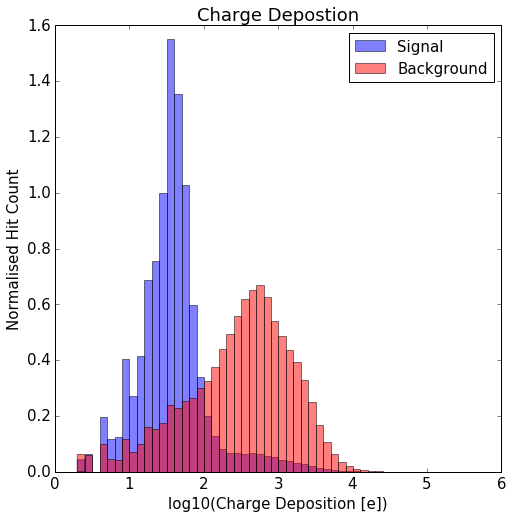

In [96]:
figsize(8, 8)
bins_for_plots = 50
plot_feature( np.log10(train.cdc.get_signal_hits()[train.cdc.edep_name] + 1), 
              np.log10(train.cdc.get_background_hits()[train.cdc.edep_name] + 1), 
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=bins_for_plots)
show()

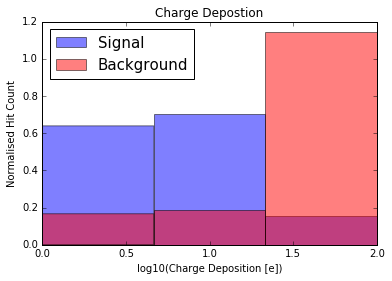

In [23]:
bins_for_plots = 50
powered_bins = np.array([31.5, 100])
plot_feature( np.digitize(train.cdc.get_signal_hits()[train.cdc.edep_name], 
                          bins=powered_bins),
              np.digitize(train.cdc.get_background_hits()[train.cdc.edep_name], 
                          bins=powered_bins),
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=3,
              uniform_bins=False)
show()

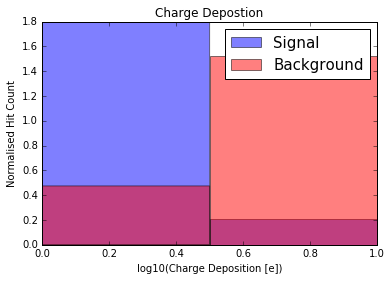

In [24]:
bins_for_plots = 50
plot_feature( np.digitize(np.log10(train.cdc.get_signal_hits()[train.cdc.edep_name] ), 
                          bins=[2]),
              np.digitize(np.log10(train.cdc.get_background_hits()[train.cdc.edep_name] ), 
                          bins=[2]),
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=2,
              uniform_bins=False)
show()

## Define Wire Features 

In [25]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc
from pandas import DataFrame
from sklearn.metrics import roc_auc_score, roc_curve

In [26]:
# Define Data
energy_feature = "Energy"
binary_energy = energy_feature + "_one_bit"
binned_energy = energy_feature+ "_two_bit"
high_bin_energy = energy_feature+ "_three_bit"
energy_feature = energy_feature + "_unbin"
board_id = "RECBE_id"
board_layer = "RECBE_layer"
layer_id = "Layer_ID"

binary_wire_features = [binary_energy, 
                        binary_energy + "_left",
                        binary_energy + "_right"]
binned_wire_features = [binned_energy, 
                        binned_energy + "_left",
                        binned_energy + "_right"]
high_bin_wire_features = [high_bin_energy, 
                          high_bin_energy + "_left",
                          high_bin_energy + "_right"]
unbin_wire_features = [energy_feature, 
                       energy_feature + "_left",
                       energy_feature + "_right"]
all_features = binary_wire_features + \
               binned_wire_features + \
               high_bin_wire_features + \
               unbin_wire_features + \
               [board_id, board_layer, layer_id]

In [27]:
factory = ClassifiersFactory()

# Define GBDT for ADC
binary_energy = SklearnClassifier(GradientBoostingClassifier(n_estimators=100),
                                  features=[energy_feature])
factory.add_classifier('ADC', binary_energy)
# Define GBDT for 1 bits
binary_neighs = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                 features=binary_wire_features + [board_id])
factory.add_classifier('Binary', binary_neighs)
# Define GBDT for 2 bits
binned_neighs = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                 features=binned_wire_features + [board_id])
factory.add_classifier('Binned', binned_neighs)
# Define GBDT for 2 bits
high_binned_neighs = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                 features=high_bin_wire_features + [board_id])
factory.add_classifier('High_Binned', high_binned_neighs)
# Define GBDT over unbinned wire features
unbin_neighs = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                 features=unbin_wire_features + [layer_id])
factory.add_classifier('Unbinned', unbin_neighs)

In [28]:
print train.cdc.n_hits, train.cdc.n_events
print train.cdc.get_measurement(train.cdc.hit_type_name).shape

1425206 2491
(1425206,)


In [29]:
# Deal with coincidence
train.cdc.sort_hits(train.cdc.hit_type_name, ascending=False, reset_index=True)
print sum(train.cdc.get_measurement(train.cdc.hit_type_name))
train_cdc_flat_id = train.cdc.get_measurement(train.cdc.flat_name, events=evt_samp[0]).astype(int)

197497.0


In [30]:
def get_data_frame(samp, events):
    flat_ids = samp.cdc.get_measurement(samp.cdc.flat_name, events=events).astype(int)
    return DataFrame(np.vstack(
                        get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events,
                                                      digitize=True, bins=[100], default=1) +\
                        get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events,
                                                      digitize=True, bins=[1, 31.5, 100], 
                                                      default=0) +\
                        get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events,
                                                      digitize=True, bins=[1.0000, 3.150, 
                                                                           10.000, 31.50,
                                                                           100.00, 315.0,
                                                                           1000.0], 
                                                      default=0) +\
                        get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events) +\
                        [recbe_positions["BoardID" ][flat_ids]] +\
                        [recbe_positions["BrdLayID"][flat_ids]] +\
                        [samp.cdc.geom.get_layers(flat_ids)]).T, columns=all_features)

In [31]:
# Train the classifier
factory.fit(get_data_frame(train, evt_samp[0]),
            train.cdc.get_measurement(train.cdc.hit_type_name, events=evt_samp[0]))

model ADC          was trained in 76.25 seconds
model Binary       was trained in 79.31 seconds
model Binned       was trained in 88.83 seconds
model High_Binned  was trained in 108.01 seconds
model Unbinned     was trained in 132.08 seconds
Totally spent 484.48 seconds on training


ClassifiersFactory([('ADC',
                     SklearnClassifier(clf=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
                                   max_depth=3, max_features=None, max_leaf_nodes=None,
                                   min_samples_leaf=1, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=100,
                                   presort='auto', random_state=None, subsample=1.0, verbose=0,
                                   warm_start=False),
                              features=['Energy_unbin'])),
                    ('Binary',
                     SklearnClassifier(clf=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
                                   max_depth=3, max_features=None, max_leaf_nodes=None,
                                   min_samples_leaf=1, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=100,
    

In [32]:
# Deal with coincidence
test.cdc.sort_hits(test.cdc.hit_type_name, ascending=False, reset_index=True)
print sum(test.cdc.get_measurement(test.cdc.hit_type_name))
test_cdc_flat_id = test.cdc.get_measurement(test.cdc.flat_name, events=test_evt_samp[0]).astype(int)

198716.0


In [33]:
# Test the classifier
bbdt_diagnostics = \
    factory.test_on(get_data_frame(test, test_evt_samp[0]), 
                    test.cdc.get_measurement(test.cdc.hit_type_name, events=test_evt_samp[0]))

In [101]:
print test.cdc.get_signal_hits()[test.cdc.hits_index_name]

[      0       1       2 ..., 1438092 1438093 1438094]


In [104]:
print bbdt_diagnostics.target

[ 1.  1.  1. ...,  0.  0.  0.]


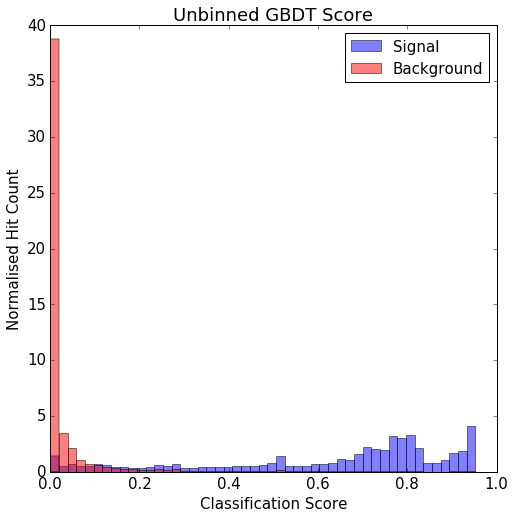

In [108]:
bins_for_plots = 50
plot_feature( bbdt_diagnostics.prediction["Unbinned"][bbdt_diagnostics.target == 1.0,1],
              bbdt_diagnostics.prediction["Unbinned"][bbdt_diagnostics.target == 0.0,1],
              xlabel="Classification Score", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Unbinned GBDT Score", 
              nbins=bins_for_plots,
              uniform_bins=True)
show()

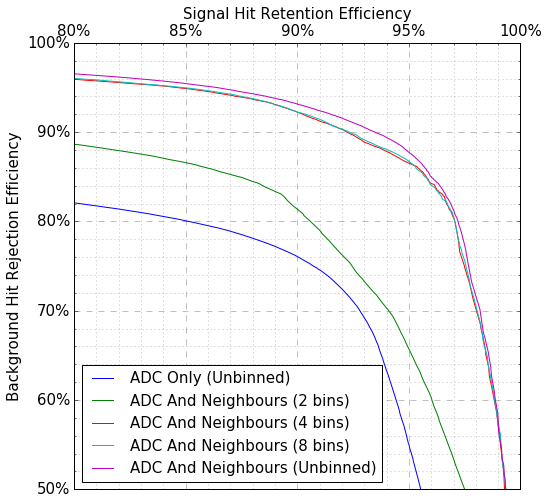

ADC
  0.872039800729
Binary
  0.913214936893
Binned
  0.964558382017
High_Binned
  0.965110522747
Unbinned
  0.968412771631


In [114]:
plot_set_font()
figsize(8, 8)
curve_dict = dict()

cla_dict = {}
cla_dict["ADC"] = "ADC Only (Unbinned)"
cla_dict["Binary"] = "ADC And Neighbours (2 bins)"
cla_dict["Binned"] = "ADC And Neighbours (4 bins)"
cla_dict["High_Binned"] = "ADC And Neighbours (8 bins)"
cla_dict["Unbinned"] = "ADC And Neighbours (Unbinned)"

plot_roc_curve(test.cdc.get_measurement(test.cdc.hit_type_name, events=test_evt_samp[0]), 
               1.0/np.log10(test.cdc.get_measurement(test.cdc.edep_name, events=test_evt_samp[0])),
         label="ADC Only (Unbinned)",
         zoom=True,
         zoom_x_lims=[80,100],
         zoom_y_lims=[50,100],
         datum_label="Hit")

for cla in factory.keys():
    if cla == "ADC":
        continue
    plot_roc_curve(test.cdc.get_measurement(test.cdc.hit_type_name, events=test_evt_samp[0]), 
             bbdt_diagnostics.prediction[cla][:,1],
             label=cla_dict[cla],
             zoom=True,
             zoom_x_lims=[80,100],
             zoom_y_lims=[50,100],
             datum_label="Hit")

plt.show()
for key, preds in bbdt_diagnostics.prediction.iteritems():
    print key
    print "  {}".format(roc_auc_score(test.cdc.get_measurement(test.cdc.hit_type_name, 
                                                               events=test_evt_samp[0]), preds[:,1]))
    curve_dict[key] = roc_curve(test.cdc.get_measurement(test.cdc.hit_type_name, events=test_evt_samp[0])
                                , preds[:,1])

In [35]:
threshold_dict = {}
for key, curve in curve_dict.iteritems():
    print np.array(curve).shape, key
    threshold_dict[key] = curve[2][np.argmin( np.abs(curve[1] - 0.80))]
pprint(threshold_dict)

(3, 286) Binary
(3, 974) Binned
(3, 2813) High_Binned
(3, 231) ADC
(3, 76259) Unbinned
{'ADC': 0.28000510063631012,
 'Binary': 0.3272775228163764,
 'Binned': 0.47767841058857646,
 'High_Binned': 0.46305913993527509,
 'Unbinned': 0.444317220287193}


In [36]:
#train.cdc.data[train.cdc.prefix+pos[2]] = - (train.cdc.data[train.cdc.prefix+pos[2]]/10. - 765)
#train.cdc.data[train.cdc.prefix+pos[1]] = train.cdc.data[train.cdc.prefix+pos[1]]/10.
#train.cdc.data[train.cdc.prefix+pos[0]] = (train.cdc.data[train.cdc.prefix+pos[0]]/10. - 641)
#train.cth.data[train.cth.prefix+pos[2]] = - (train.cth.data[train.cth.prefix+pos[2]]/10. - 765)
#train.cth.data[train.cth.prefix+pos[1]] = train.cth.data[train.cth.prefix+pos[1]]/10.
#train.cth.data[train.cth.prefix+pos[0]] = (train.cth.data[train.cth.prefix+pos[0]]/10. - 641)

In [37]:
pos = list()
pos += ["MCPos.fP.fX"]
pos += ["MCPos.fP.fY"]
pos += ["MCPos.fP.fZ"]

p = dict()
p["cdc"] = dict()
p["cdc"]["x"] =  train.cdc.prefix + pos[2]
p["cdc"]["y"] =  train.cdc.prefix + pos[1]
p["cdc"]["z"] =  train.cdc.prefix + pos[0]
p["cth"] = dict()
p["cth"]["x"] =  train.cth.prefix + pos[2]
p["cth"]["y"] =  train.cth.prefix + pos[1]
p["cth"]["z"] =  train.cth.prefix + pos[0]

data was predicted by ADC          in 0.00 seconds
data was predicted by Binary       in 0.00 seconds
data was predicted by Binned       in 0.00 seconds
data was predicted by High_Binned  in 0.00 seconds
data was predicted by Unbinned     in 0.00 seconds
Totally spent 0.01 seconds on prediction


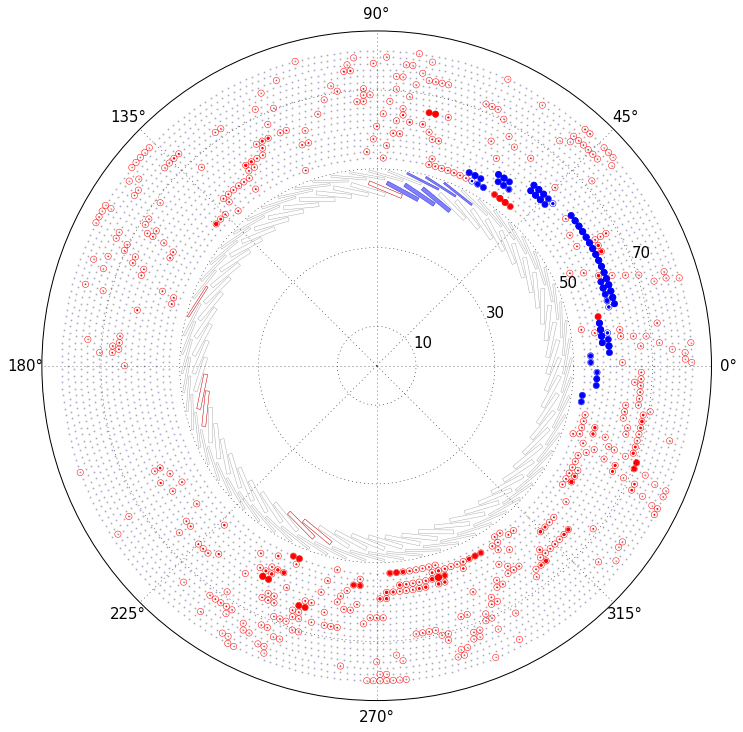

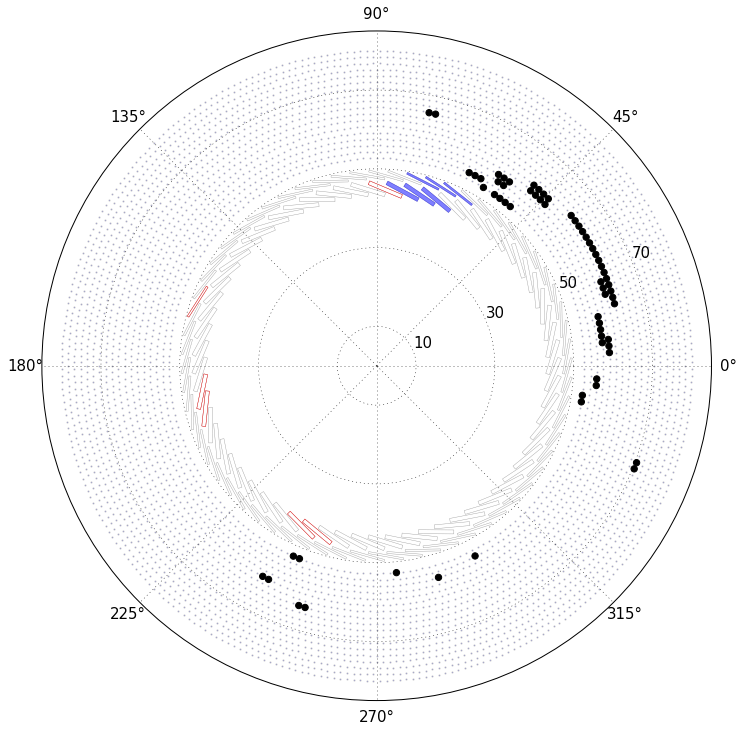

In [38]:
classifier = "Binned"
for evt in range(99,100):
    # Plot the output
    output = np.zeros(4482)
    geom_ids = test.cdc.get_measurement(test.cdc.flat_name, evt).astype(int)
    output[geom_ids] = factory.predict_proba(get_data_frame(test, evt))[classifier][:,1]
    cut = (output >= threshold_dict[classifier])

    for output, outline in zip([output, cut], [True,False]): 
        if not outline:
            plot_output(test.cdc.get_hit_types(evt),
                                      test.cdc.geom, size=output*40,
                        sig_color="Black", bkg_color="Black")
        # Add hit outlines
        if outline:
            plot_output(test.cdc.get_hit_types(evt),
                                      test.cdc.geom, size=output*40)
            plot_add_outlines(test.cdc.get_hit_types(evt), 
                              test.cdc.geom)
        # Add volume outlines
        plot_add_cth_outlines(test.cth.geom)
        # Add the CTH vols with hits
        cth_vol_types = test.cth.get_vol_types(evt)
        plot_add_cth(cth_vol_types, test.cth.get_trig_vector(evt)[0], test.cth.geom)
        cth_hits = test.cth.get_events(evt)
        cdc_hits = test.cdc.get_events(evt)
        #plt.scatter(cth_hits[p["cth"]["x"]], 
        #            cth_hits[p["cth"]["y"]], 
        #            s=1, transform=gca().transData._b)
        #plt.scatter(cdc_hits[p["cdc"]["x"]], 
        #            cdc_hits[p["cdc"]["y"]], 
        #            s=1, color="black",
        #            transform=gca().transData._b)
        plt.show()
    print "====================================================================="

## Import Event Sample

In [39]:
sig_evts = data_import_sample(signal_files[2], back_files[2], 
                              these_cuts=["Trig","Track","700"],
                              branches=these_branches)
bck_evts = data_import_sample(signal_files[2], back_files[2], 
                              these_cuts=["Trig","Track","700"],
                              branches=these_branches)

Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Using cuts
{ 'CDC': 'CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': 'CTHHit.fGoodTrig == 1 && CTHHit.fGoodTrack == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Trimming Background Events
CTH Sig Events 3419 
CTH Back Events 3419 
CDC Sig Events 3419 
CDC Back Events 3419 
Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC

In [40]:
bck_evts.cdc.trim_hits(sig_evts.cdc.hit_type_name, values=[False])

In [41]:
sig_evts.cth.set_trigger_time()
bck_evts.cth.set_trigger_time()

In [42]:
remove_coincidence(sig_evts)
remove_coincidence(bck_evts)

### Classify Event Sample

In [43]:
evt_scores = {}
evt_scores["Signal"] = {}
evt_scores["Background"] = {}

In [72]:
for etype, samp in zip(["Signal", "Background"],
                       [sig_evts, bck_evts]):
    for cla in factory.keys():
        print etype, cla
        evt_scores[etype][cla] = np.array([sum(factory[cla].predict_proba(get_data_frame(samp, evt))[:,1])
                                           for evt in range(samp.cdc.n_events)])

Signal Unbinned
Signal ADC
Signal Binary
Signal Binned
Signal High_Binned
Signal Unbinned
Background Unbinned
Background ADC
Background Binary
Background Binned
Background High_Binned
Background Unbinned


In [86]:
for etype, samp in zip(["Signal", "Background"],
                       [sig_evts, bck_evts]):
    print etype, cla
    evt_scores[etype]["ADC_2"] = np.array([sum((samp.cdc.get_measurement(samp.cdc.edep_name, 
                                                                         events=evt)) < 100.0)
                                           for evt in range(samp.cdc.n_events)])

Signal Unbinned
Background Unbinned


(<matplotlib.axes._subplots.AxesSubplot at 0x7efd61377210>,
 <matplotlib.figure.Figure at 0x7efd60c221d0>)

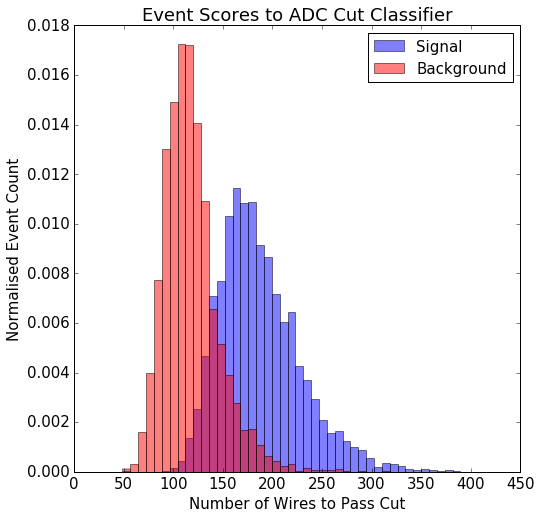

In [119]:
plot_feature( evt_scores["Signal"]["ADC_2"], 
              evt_scores["Background"]["ADC_2"], 
              xlabel="Number of Wires to Pass Cut", ylabel="Normalised Event Count", 
              xlog=False,
              title="Event Scores to ADC Cut Classifier", 
              nbins=bins_for_plots)

(<matplotlib.axes._subplots.AxesSubplot at 0x7efd60c8e090>,
 <matplotlib.figure.Figure at 0x7efd6137eb90>)

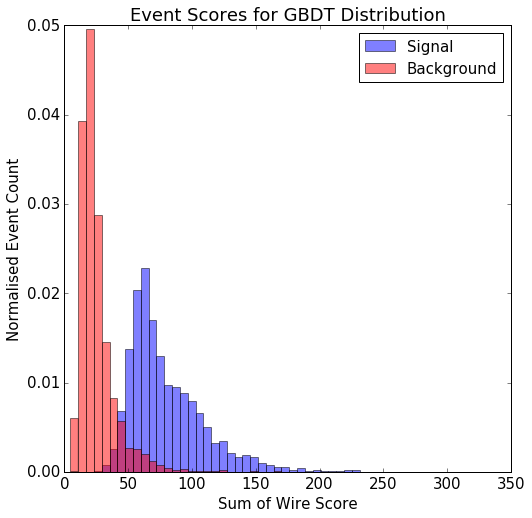

In [120]:
plot_feature( evt_scores["Signal"]["Unbinned"], 
              evt_scores["Background"]["Unbinned"], 
              xlabel="Sum of Wire Score", ylabel="Normalised Event Count", 
              xlog=False,
              title="Event Scores for GBDT Distribution", 
              nbins=bins_for_plots)

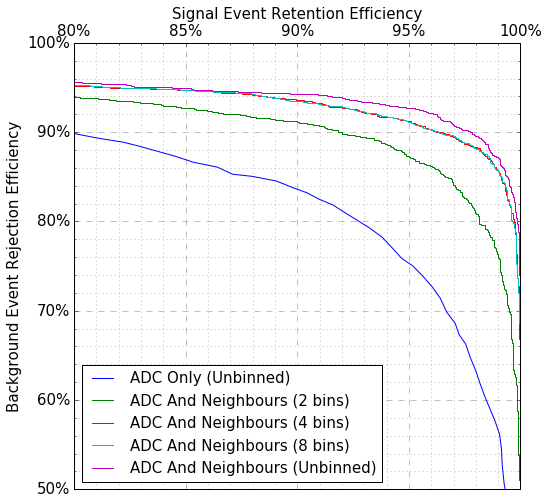

In [121]:
labels = np.zeros(sig_evts.cdc.n_events + bck_evts.cdc.n_events)
labels[:sig_evts.cdc.n_events] = 1
plot_roc_curve(labels, np.append(evt_scores["Signal"]["ADC_2"],  
                                 evt_scores["Background"]["ADC_2"]),
                                 label="ADC Only (Unbinned)", zoom=True,
                                 zoom_x_lims=[80,100], zoom_y_lims=[50,100],
                                 datum_label="Event")
for cla in factory.keys():
    if cla == "ADC": continue
    plot_roc_curve(labels, np.append(evt_scores["Signal"][cla],  
                                     evt_scores["Background"][cla]),
                                     label=cla_dict[cla], zoom=True,
                                     zoom_x_lims=[80,100], zoom_y_lims=[50,100],
                                     datum_label="Event")
plt.show()